In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(98765)

In [2]:
run_full_CP = False
# flag for whether to run full conformal prediction
# requires the nonconformist library

TOL = 1e-8

######################################
# Define regression algorithm (for full conformal)
######################################
if(run_full_CP):
    from nonconformist.nc import RegressorNormalizer
    from nonconformist.nc import AbsErrorErrFunc
    from nonconformist.base import RegressorAdapter
    from nonconformist.nc import RegressorNc
    from nonconformist.cp import IcpRegressor

    class leastsq_minL2_wrapper(RegressorAdapter):

        def __init__(self, model=None, fit_params=None, tol=TOL):
            super(leastsq_minL2_wrapper, self).__init__(model, fit_params)
            self.betahat = 0
            self.tol = tol
            
        def fit(self, x, y):
            uX,dX,vX = np.linalg.svd(x)
            rX = (dX>=dX[0]*self.tol).sum()
            self.betahat = (vX[:rX].T/dX[:rX]).dot(uX[:,:rX].T.dot(y))
        
        def predict(self, x):
            return x.dot(self.betahat)
        
        
######################################
# Define regression algorithm (for all other methods)
######################################

def leastsq_minL2(X,Y,X1,tol=TOL):
    uX,dX,vX = np.linalg.svd(X)
    rX = (dX>=dX[0]*tol).sum()
    betahat = (vX[:rX].T/dX[:rX]).dot(uX[:,:rX].T.dot(Y))
    return X1.dot(betahat)




In [3]:
def compute_PIs(X,Y,X1,alpha,fit_muh_fun, min_Y, max_Y, run_full_CP=True):
    n = len(Y)
    n1 = X1.shape[0]
    
   
    ###############################
    # Naive & jackknife/jack+/jackmm
    ###############################
    
    muh_vals = fit_muh_fun(X,Y,np.r_[X,X1])
    resids_naive = np.abs(Y-muh_vals[:n])
    muh_vals_testpoint = muh_vals[n:]
    resids_LOO = np.zeros(n)
    muh_LOO_vals_testpoint = np.zeros((n,n1))
    for i in range(n):
        muh_vals_LOO = fit_muh_fun(np.delete(X,i,0),np.delete(Y,i),\
                                   np.r_[X[i].reshape((1,-1)),X1])
        resids_LOO[i] = np.abs(Y[i] - muh_vals_LOO[0])
        muh_LOO_vals_testpoint[i] = muh_vals_LOO[1:]
    ind_q = (np.ceil((1-alpha)*(n+1))).astype(int)

    ###############################
    # CV+
    ###############################

    K = 10
    n_K = np.floor(n/K).astype(int)
    base_inds_to_delete = np.arange(n_K).astype(int)
    resids_LKO = np.zeros(n)
    muh_LKO_vals_testpoint = np.zeros((n,n1))
    for i in range(K):
        inds_to_delete = (base_inds_to_delete + n_K*i).astype(int)
        muh_vals_LKO = fit_muh_fun(np.delete(X,inds_to_delete,0),np.delete(Y,inds_to_delete),\
                                   np.r_[X[inds_to_delete],X1])
        resids_LKO[inds_to_delete] = np.abs(Y[inds_to_delete] - muh_vals_LKO[:n_K])
        for inner_K in range(n_K):
            muh_LKO_vals_testpoint[inds_to_delete[inner_K]] = muh_vals_LKO[n_K:]
    ind_Kq = (np.ceil((1-alpha)*(n+1))).astype(int)

    ###############################
    # split conformal
    ###############################
    
    idx = np.random.permutation(n)
    n_half = int(np.floor(n/2))
    idx_train, idx_cal = idx[:n_half], idx[n_half:]
    muh_split_vals = fit_muh_fun(X[idx_train],Y[idx_train],np.r_[X[idx_cal],X1])
    resids_split = np.abs(Y[idx_cal]-muh_split_vals[:(n-n_half)])
    muh_split_vals_testpoint = muh_split_vals[(n-n_half):]
    ind_split = (np.ceil((1-alpha)*(n-n_half+1))).astype(int)

    
    ###############################
    # Full Conformal
    ###############################
    if(run_full_CP):
        y_num = 300
        y_trial_vec = np.linspace(min_Y,max_Y,num=y_num)
        full_predictions = np.zeros((n1,2))
        full_C = []
        for i in range(n1):
            pi_y = np.zeros(y_num)
            C = []
            for j in range(y_num):
                y_trial = y_trial_vec[j]
                X_aug = np.r_[X1[i].reshape((1,-1)),X]
                Y_aug = np.r_[y_trial,Y]
                
                muh_vals_full = fit_muh_fun(X_aug,Y_aug,X_aug)
                resids_full = np.abs(Y_aug - muh_vals_full)
                
                pi_y = (1+np.sum(resids_full[1:]<=resids_full[0])) / (n+1)
                if (n+1)*pi_y <= np.ceil( (1-alpha)*(n+1) ):
                    C.append(y_trial)
        
            if len(C)>0:
                full_predictions[i,0] = min(C)
                full_predictions[i,1] = max(C)
        
            full_C.append(C)
    
    ###############################
    # construct prediction intervals
    ###############################

    PIs_dict = {'naive' : pd.DataFrame(\
                    np.c_[muh_vals_testpoint - np.sort(resids_naive)[ind_q-1], \
                        muh_vals_testpoint + np.sort(resids_naive)[ind_q-1]],\
                           columns = ['lower','upper']),\
                'jackknife' : pd.DataFrame(\
                    np.c_[muh_vals_testpoint - np.sort(resids_LOO)[ind_q-1], \
                        muh_vals_testpoint + np.sort(resids_LOO)[ind_q-1]],\
                           columns = ['lower','upper']),\
                'jackknife+' : pd.DataFrame(\
                    np.c_[np.sort(muh_LOO_vals_testpoint.T - resids_LOO,axis=1).T[-ind_q], \
                        np.sort(muh_LOO_vals_testpoint.T + resids_LOO,axis=1).T[ind_q-1]],\
                           columns = ['lower','upper']),\
                'jackknife-mm' : pd.DataFrame(\
                    np.c_[muh_LOO_vals_testpoint.min(0) - np.sort(resids_LOO)[ind_q-1], \
                           muh_LOO_vals_testpoint.max(0) + np.sort(resids_LOO)[ind_q-1]],\
                           columns = ['lower','upper']),\
                'CV+' : pd.DataFrame(\
                    np.c_[np.sort(muh_LKO_vals_testpoint.T - resids_LKO,axis=1).T[-ind_Kq], \
                        np.sort(muh_LKO_vals_testpoint.T + resids_LKO,axis=1).T[ind_Kq-1]],\
                           columns = ['lower','upper']),\
                'split' : pd.DataFrame(\
                    np.c_[muh_split_vals_testpoint - np.sort(resids_split)[ind_split-1], \
                           muh_split_vals_testpoint + np.sort(resids_split)[ind_split-1]],\
                            columns = ['lower','upper'])}

    if(run_full_CP):
        PIs_dict['full'] = pd.DataFrame(np.c_[full_predictions[:,0], full_predictions[:,1]],\
                           columns = ['lower','upper'])
    
    return pd.concat(PIs_dict.values(), axis=1, keys=PIs_dict.keys())


In [4]:
# simulation
n = 100; 
n1 = 100
SNR = 10
ntrial = 50
alpha = 0.1
dim_vals = np.arange(5,205,5)

if(run_full_CP):
    method_names = ['naive','jackknife','jackknife+','jackknife-mm','CV+','split', 'full']
else:
    method_names = ['naive','jackknife','jackknife+','jackknife-mm','CV+','split']

results = pd.DataFrame(columns = ['itrial','d','method','coverage','width'])
for d in dim_vals:
    for itrial in range(ntrial):
        beta = np.random.normal(size=d)
        beta = beta/np.sqrt((beta**2).sum()) * np.sqrt(SNR)
        X = np.random.normal(size=(n,d))
        Y = X.dot(beta) + np.random.normal(size=n)
        
        min_Y = Y.min() - 0.1 * (Y.max()-Y.min())
        max_Y = Y.max() + 0.1 * (Y.max()-Y.min())
        
        X1 = np.random.normal(size=(n1,d))
        Y1 = X1.dot(beta) + np.random.normal(size=n1)
        
        PIs = compute_PIs(X,Y,X1,alpha,leastsq_minL2, min_Y, max_Y, run_full_CP)
        for method in method_names:
            coverage = ((PIs[method]['lower'] <= Y1)&(PIs[method]['upper'] >= Y1)).mean()
            width = (PIs[method]['upper'] - PIs[method]['lower']).mean()
            results.loc[len(results)]=[itrial,d,method,coverage,width]

results.to_csv('jackknife_simulation_results.csv',index=False)

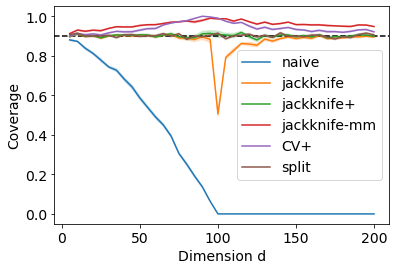

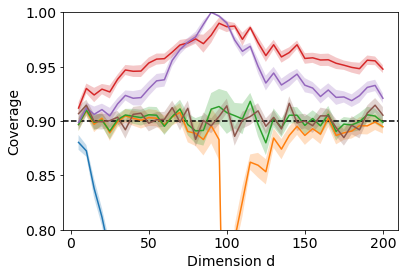

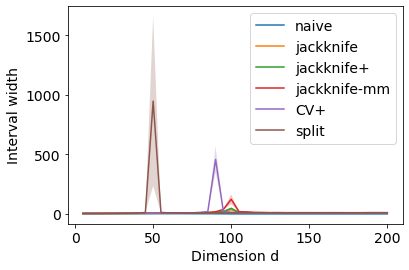

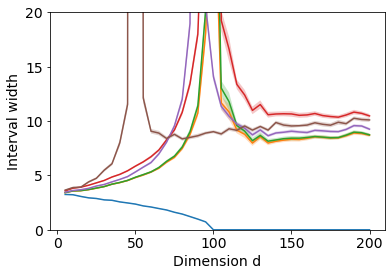

In [5]:
# plot simulation results
plt.rcParams.update({'font.size': 14})

plt.axhline(1-alpha,linestyle='dashed',c='k')
for method in method_names:
    coverage_mean = results[results['method']==method].groupby('d')['coverage'].mean()
    coverage_SE = results[results['method']==method].groupby('d')['coverage'].std()\
        /np.sqrt(ntrial)
    plt.plot(dim_vals,coverage_mean,label=method)
    plt.fill_between(dim_vals,coverage_mean-coverage_SE,coverage_mean+coverage_SE,alpha = 0.25)
plt.xlabel('Dimension d')
plt.ylabel('Coverage')
plt.legend()
plt.savefig('jackknife_simulation_coverage.png',dpi=400,bbox_inches='tight')
plt.show()

plt.axhline(1-alpha,linestyle='dashed',c='k')
for method in method_names:
    coverage_mean = results[results['method']==method].groupby('d')['coverage'].mean()
    coverage_SE = results[results['method']==method].groupby('d')['coverage'].std()\
        /np.sqrt(ntrial)
    plt.plot(dim_vals,coverage_mean,label=method)
    plt.fill_between(dim_vals,coverage_mean-coverage_SE,coverage_mean+coverage_SE,alpha = 0.25)
plt.ylim(0.8,1.0)
plt.xlabel('Dimension d')
plt.ylabel('Coverage')
plt.savefig('jackknife_simulation_coverage_zoomin.png',dpi=400,bbox_inches='tight')
plt.show()

for method in method_names:
    width_mean = results[results['method']==method].groupby('d')['width'].mean()
    width_SE = results[results['method']==method].groupby('d')['width'].std()/np.sqrt(ntrial)
    plt.plot(dim_vals,width_mean,label=method)
    plt.fill_between(dim_vals,width_mean-width_SE,width_mean+width_SE,alpha = 0.25)
plt.xlabel('Dimension d')
plt.ylabel('Interval width')
plt.legend()
plt.savefig('jackknife_simulation_width.png',dpi=400,bbox_inches='tight')
plt.show()

for method in method_names:
    width_mean = results[results['method']==method].groupby('d')['width'].mean()
    width_SE = results[results['method']==method].groupby('d')['width'].std()/np.sqrt(ntrial)
    plt.plot(dim_vals,width_mean,label=method)
    plt.fill_between(dim_vals,width_mean-width_SE,width_mean+width_SE,alpha = 0.25)
plt.ylim(0,20)
plt.xlabel('Dimension d')
plt.ylabel('Interval width')
plt.savefig('jackknife_simulation_width_zoomin.png',dpi=400,bbox_inches='tight')
plt.show()

